## Import Libraries

In [1]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)


import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)

from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain 

from tensorflow.keras import datasets, layers, models
from tensorflow.keras import regularizers

## Read Data

In [2]:
df = pd.read_csv("Data/Original/testing.csv")  #test-set for financial evaluation

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,02-04-2018,893.000000,900.950012,886.500000,892.950012,879.384521,5712065
1,03-04-2018,891.000000,901.700012,885.250000,899.549988,885.884277,6364728
2,04-04-2018,904.700012,911.799988,892.049988,894.900024,881.304932,6498407
3,05-04-2018,905.099976,910.000000,903.500000,908.200012,894.402832,3898676
4,06-04-2018,908.000000,918.500000,905.000000,911.000000,897.160339,4418462
...,...,...,...,...,...,...,...
323,24-07-2019,1273.500000,1278.800049,1253.550049,1259.099976,1247.546387,6943982
324,25-07-2019,1264.000000,1269.050049,1227.000000,1231.500000,1220.199707,9968545
325,26-07-2019,1231.500000,1242.500000,1210.000000,1213.800049,1202.662231,9320481
326,29-07-2019,1216.900024,1222.000000,1205.099976,1210.949951,1199.838257,8058035


In [4]:
train_dir = os.path.join('Images', 'Training')
validation_dir = os.path.join('Images', 'Validation')

In [5]:
train_buy_dir = os.path.join(train_dir, 'Buy')  # directory with our training  Buy pictures
train_hold_dir = os.path.join(train_dir, 'Hold')  # directory with our training Hold pictures
train_sell_dir = os.path.join(train_dir, 'Sell')  # directory with our training Sell pictures
validation_buy_dir = os.path.join(validation_dir, 'Buy')  # directory with our validation Buy pictures
validation_hold_dir = os.path.join(validation_dir, 'Hold')  # directory with our validation Hold pictures
validation_sell_dir = os.path.join(validation_dir, 'Sell')  # directory with our validation Sell pictures

num_buy_tr = len(os.listdir(train_buy_dir))
num_hold_tr = len(os.listdir(train_hold_dir))
num_sell_tr = len(os.listdir(train_sell_dir))

num_buy_val = len(os.listdir(validation_buy_dir))
num_hold_val = len(os.listdir(validation_hold_dir))
num_sell_val = len(os.listdir(validation_sell_dir))

total_train = num_buy_tr + num_hold_tr + num_sell_tr
total_val = num_buy_val + num_hold_val + num_sell_val



print("Total training images:", total_train)
print("Total validation images:", total_val)

Total training images: 1732
Total validation images: 308


In [6]:
# initializing parameters for further use
batch_size = 32
epochs = 100
IMG_HEIGHT = 12
IMG_WIDTH = 15

# ***Data Augmentation***

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen_train = ImageDataGenerator(
    rescale=1./255,featurewise_center=True,
    
    width_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='reflect',
    )

validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen =image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,color_mode="rgb",
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='sparse')


Found 1732 images belonging to 3 classes.


In [8]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,color_mode="rgb",
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='sparse')

Found 308 images belonging to 3 classes.


# ***Model***

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import regularizers
model = keras.Sequential(
    [
        keras.Input(shape=(12,15,3)),
        layers.Conv2D(32,kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64,kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25,seed=0),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(3, activation="softmax"),
    ]
)

model.summary()
model.compile(optimizer='rmsprop',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 13, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 11, 64)         18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

# ***Computational Performance***

In [10]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

C:\Users\rialk\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100


C:\Users\rialk\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


54/54 [==============================] - 7s 68ms/step - loss: 1.0483 - accuracy: 0.4740 - val_loss: 1.0756 - val_accuracy: 0.4132
Epoch 2/100
54/54 [==============================] - 3s 54ms/step - loss: 1.0152 - accuracy: 0.4929 - val_loss: 1.0495 - val_accuracy: 0.4688
Epoch 3/100
54/54 [==============================] - 3s 55ms/step - loss: 1.0042 - accuracy: 0.5023 - val_loss: 1.0998 - val_accuracy: 0.2847
Epoch 4/100
54/54 [==============================] - 3s 53ms/step - loss: 1.0012 - accuracy: 0.5206 - val_loss: 1.0808 - val_accuracy: 0.3090
Epoch 5/100
54/54 [==============================] - 3s 54ms/step - loss: 0.9919 - accuracy: 0.5259 - val_loss: 1.1132 - val_accuracy: 0.2986
Epoch 6/100
54/54 [==============================] - 3s 53ms/step - loss: 0.9865 - accuracy: 0.5335 - val_loss: 1.2201 - val_accuracy: 0.2778
Epoch 7/100
54/54 [==============================] - 3s 56ms/step - loss: 0.9783 - accuracy: 0.5365 - val_loss: 1.2045 - val_accuracy: 0.3021
Epoch 8/100
54/54 

In [11]:
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                 directory='Images/Testing',
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='sparse')

Found 328 images belonging to 3 classes.


In [12]:
val_loss,val_acc =model.evaluate(val_data_gen,steps=len(test_data_gen),verbose=0)
val_acc

0.4675324559211731

In [13]:
test_loss,test_acc = model.evaluate(test_data_gen,steps=len(test_data_gen),verbose=0)
test_acc

0.4146341383457184

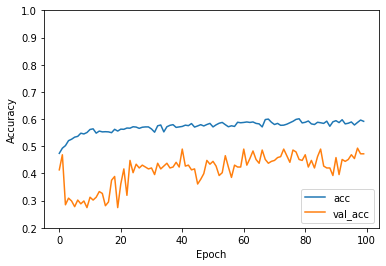

In [14]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

## ***Financial Evaluation***

In [15]:
from keras.preprocessing import image
labels_pred=[]

PATH = os.getcwd()
data_path =  'Images/Testing'
data_dir_list = os.listdir(data_path)

img_data_list=[]
for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    for img in img_list:
        img_path = data_path + '/'+ dataset + '/'+ img
        img = keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        test_img = image.img_to_array(img)/255
        test_img=np.array(test_img)
        img_array = tf.expand_dims(test_img, 0)  # Create batch axis
        labels_pred.append(np.argmax(model.predict(img_array),axis=1)[0])
        
print(labels_pred)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 1]


In [16]:
df['prediction']=labels_pred
icost=[]
buy_l=[]
cost=0
buy_c=0
buy=0
sell=0
win=0
loss=0

for i in df.index:
    if(df['prediction'][i]==0):
        if(buy_c<=0):
            buy_c=buy_c+1
            buy=buy+1
            cost=cost - df['Adj Close'][i]
            x=df['Adj Close'][i]
            #print(cost)
            buy_l.append(x)
            print("date : {}, cost : {},buy_c:{},price:{}".format(i, cost,buy_c,x),'Buy')
    if(df['prediction'][i]==2):
        y=df['Adj Close'][i]
        if(buy_c>=1):
            if(y-x>0):
                buy_c=buy_c-1
                sell=sell+1
                cost=cost+df['Adj Close'][i]
                print("date : {}, cost :{},buy_c:{},price:{}".format(i, cost,buy_c,y),"Sell")
                if((buy>0) & (sell>0)):
                    if(y-x<0):
                        loss=loss+1
                    if(y-x>0):
                        win=win+1
                    icost.append(y-x)
    if(df['prediction'][i]==1):
        continue
 
print(cost)
#print((cost-icost)/icost)
print(buy)
print(sell)
print("win:",win)
print('loss:',loss)

date : 28, cost : -974.2216189999999,buy_c:1,price:974.2216189999999 Buy
date : 58, cost :22.896728000000167,buy_c:0,price:997.1183470000001 Sell
date : 61, cost : -934.0906379999999,buy_c:1,price:956.9873660000001 Buy
date : 68, cost :34.4893790000001,buy_c:0,price:968.580017 Sell
date : 72, cost : -1037.928956,buy_c:1,price:1072.418335 Buy
date : 100, cost :219.8724360000001,buy_c:0,price:1257.801392 Sell
date : 107, cost : -997.998902,buy_c:1,price:1217.8713380000002 Buy
date : 114, cost :243.00817800000004,buy_c:0,price:1241.00708 Sell
date : 115, cost : -998.642945,buy_c:1,price:1241.651123 Buy
date : 123, cost :243.60266000000001,buy_c:0,price:1242.245605 Sell
date : 125, cost : -976.795167,buy_c:1,price:1220.397827 Buy
date : 200, cost :249.5476060000001,buy_c:0,price:1226.342773 Sell
date : 208, cost : -966.342165,buy_c:1,price:1215.889771 Buy
date : 213, cost :312.21716100000003,buy_c:0,price:1278.559326 Sell
date : 214, cost : -953.7585469999999,buy_c:1,price:1265.975708 Buy
